In [53]:
import msprime
import tskit
import numpy as np
import math
import random
from collections import defaultdict
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt    
import time


def identify_unique_paths(ts):
    """
    Finds all of the paths within the incomplete ARG, stored as a tskit tree sequence
    
    Input:
    - ts: tskit tree sequence
    
    Output:
    - all_paths: list, unique paths within the ARG
    """
    # make the (incomplete) ARG
    topology = defaultdict(list)
    for tree in ts.trees():
        for k, v in chain(tree.parent_dict.items()):
            if v not in topology[k]:
                topology[k].append(v)
    G = nx.DiGraph(dict(topology))

    #unique paths up the ARG
    gmrca = ts.node(ts.num_nodes-1).id
    all_paths = []
    for sample in ts.samples():
        paths = nx.all_simple_paths(G, source=sample, target=gmrca)
        all_paths.extend(paths)
    return all_paths

def create_sample_locations_array(paths, sample_locs):
    """
    Expands sample locations to pair with the unique paths. Accounts for samples having multiple
    paths.
    
    Inputs:
    - paths: list, unique paths within the ARG. Output of identify_unique_paths(). If not
        provided, this will be calculated
    - sample_locs: numpy array, sample locations
    
    Output:
    - path_locs: numpy array, sample locations expanded to match number of paths
    """
    sample_locs_array = []
    for path in paths:
        sample_locs_array.append([sample_locs[path[0]]])
    path_locs = np.array(sample_locs_array)
    return path_locs

def link_node_with_path(ts, paths):
    """
    Adds paths from internal nodes to the root to the paths list used for calculating the
    covariance matrix. Could potentially only do one of the two recombination nodes, but keeping
    it simple for now

    Inputs:
    - ts: tskit tree sequence
    - paths: list, unique paths within the ARG. Output of identify_unique_paths().

    Output:
    - path_list: list, updated paths list
    """
    path_list = []
    for node in ts.nodes():
        if node.flags == tskit.NODE_IS_SAMPLE or node.time == ts.max_root_time:
            continue
        for i in range(len(paths)):
            if node.id in paths[i]:
                path_list.append(paths[i][paths[i].index(node.id):])
                break
    return path_list

def calc_covariance_matrix(paths, ts):
    """
    Calculates the covariance matrix between paths in a full ARG, stored as a tskit tree sequence.
    
    Inputs:
    - paths: list, unique paths within the ARG. Output of identify_unique_paths()
    - ts: tskit tree sequence. Needed for node times
    
    Output:
    - times: numpy array, shared times between the paths within the ARG
    """
    edges = ts.tables.edges
    parent_list = list(edges.parent)
    child_list = list(edges.child)
    gmrca = ts.node(ts.num_nodes-1).id
    tgmrca = ts.node(gmrca).time
    times = np.empty((len(paths),len(paths)))
    tree = ts.first()
    for i, p in enumerate(paths):
        for j in range(i+1):
            intersect = list(set(p).intersection(paths[j]))
            if i == j:
                times[i,j] = tgmrca
            elif intersect == [gmrca]:
                times[i,j] = 0
            else:
                edges = []
                for child in intersect:
                    if child != gmrca:
                        edges.append(ts.node(parent_list[child_list.index(child)]).time - ts.node(child).time)
                times[i,j] = np.sum(edges) # Do I need np.unique()? Ask Matt, because it was previously in his
            times[j,i] = times[i,j]
    return times
    
def locate_mle_gmrca(inv_sigma_22, sample_locs):
    """
    Locates the maximum likelihood estimate of the grand most recent common ancestor based on the covariance
    matrix between paths and sample locations (Equation 5.6 from 
    https://lukejharmon.github.io/pcm/pdf/phylogeneticComparativeMethods.pdf). Currently, requires simga_22
    to be pre-inverted (may be worth adding both options in future).
    
    Inputs:
    - inv_sigma_22: numpy array, inverted covariance matrix between paths at sample time
    - sample_locs: numpy array, sample locations expanded to match number of paths. Output of
        create_sample_locations_array().
    
    Output:
    - u1: float, maximum likelihood estimate of the grand most recent common ancestor (GMRCA). Output of 
        locate_mle_gmrca().
    """
    k = len(inv_sigma_22)
    a1 = np.matmul(np.matmul(np.ones(k), inv_sigma_22), np.ones(k).reshape(-1,1))
    a2 = np.matmul(np.matmul(np.ones(k), inv_sigma_22), sample_locs)
    u1 = a2/a1
    return u1

def estimate_mle_dispersal(Tinv, locs):
    '''
    MLE dispersal estimate
    
    parameters
    ----------
    Tinv: inverse covariance matrix among sample locations
    locs: sample locations
    '''
    
    k = len(locs) #number of paths
    # find MLE MRCA location (eqn 5.6 Harmon book)
    a1 = np.matmul(np.matmul(np.ones(k), Tinv), np.ones(k).reshape(-1,1))
    a2 = np.matmul(np.matmul(np.ones(k), Tinv), locs)
    ahat = a2/a1
    # find MLE dispersal rate (eqn 5.7 Harmon book)
    x = locs.reshape(-1,1) #make locations a column vector
    R1 = x - ahat * np.ones(k).reshape(-1,1)
    Rhat = np.matmul(np.matmul(np.transpose(R1), Tinv), R1) #/ (k-1)
    return Rhat[0]

def reconstruct_node_locations(ts, paths, sample_locs):
    """
    Calculates the location of ancestral nodes using conditional multivariate normal distribution.

    Inputs:
    - ts: tskit tree sequence. Needed for node times
    - paths: list, unique paths within the ARG. Output of identify_unique_paths()
    - sample_locs: list of sample locations, one location per sample

    Outputs:
    - node_times: list, time of nodes from present
    - node_locs: list, location of nodes
    """
    sample_locs_array = create_sample_locations_array(paths=paths, sample_locs=sample_locs) # expands locs
    node_paths = link_node_with_path(ts=ts, paths=paths)
    all_paths = node_paths + paths
    print(all_paths)
    sigma = calc_covariance_matrix(paths=all_paths, ts=ts)
    sigma_11 = sigma[0:sigma.shape[0]-len(paths),0:sigma.shape[1]-len(paths)]
    sigma_12 = sigma[0:sigma.shape[0]-len(paths),sigma.shape[1]-len(paths):sigma.shape[1]]
    sigma_21 = sigma[sigma.shape[0]-len(paths):sigma.shape[0],0:sigma.shape[1]-len(paths)]
    sigma_22 = sigma[sigma.shape[0]-len(paths):sigma.shape[0],sigma.shape[1]-len(paths):sigma.shape[1]]
    inv_sigma_22 = np.linalg.pinv(sigma_22)
    dispersal_rate = estimate_mle_dispersal(inv_sigma_22, sample_locs_array)
    u1 = locate_mle_gmrca(inv_sigma_22=inv_sigma_22, sample_locs=sample_locs_array)
    cmvn_u = u1 + np.dot(np.dot(sigma_12, inv_sigma_22),sample_locs_array - u1)
    cmvn_sigma = sigma_11 - np.dot(np.dot(sigma_12, inv_sigma_22), sigma_21)
    node_times = ts.tables.nodes.time
    node_locs = np.concatenate((sample_locs, np.transpose(cmvn_u)[0], u1))
    return node_times, node_locs, dispersal_rate, sigma_22

# Example 1

In [14]:
tables = tskit.TableCollection(sequence_length=1e3)

node_table = tables.nodes
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 0
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 1
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 2
node_table.add_row(time=1, flags=msprime.NODE_IS_RE_EVENT)  # Node 3
node_table.add_row(time=1, flags=msprime.NODE_IS_RE_EVENT)  # Node 4
node_table.add_row(time=2)  # Node 5
node_table.add_row(time=3)  # Node 6
node_table.add_row(time=4, flags=msprime.NODE_IS_RE_EVENT)  # Node 7
node_table.add_row(time=4, flags=msprime.NODE_IS_RE_EVENT)  # Node 8
node_table.add_row(time=5)  # Node 5
node_table.add_row(time=6)  # Node 6

edge_table = tables.edges
edge_table.add_row(left=0, right=1e3, parent=6, child=0)
edge_table.add_row(left=0, right=500, parent=3, child=1)
edge_table.add_row(left=500, right=1e3, parent=4, child=1)
edge_table.add_row(left=0, right=1e3, parent=5, child=2)
edge_table.add_row(left=0, right=500, parent=6, child=3)
edge_table.add_row(left=500, right=1e3, parent=5, child=4)
edge_table.add_row(left=0, right=250, parent=7, child=5)
edge_table.add_row(left=250, right=1e3, parent=8, child=5)
edge_table.add_row(left=0, right=1e3, parent=9, child=6)
edge_table.add_row(left=0, right=250, parent=9, child=7)
edge_table.add_row(left=250, right=1e3, parent=10, child=8)
edge_table.add_row(left=250, right=1e3, parent=10, child=9)

tables.sort()


ts = tables.tree_sequence()

print(ts.draw_text())

6.00┊       ┊  10   ┊  10   ┊  
    ┊       ┊  ┏┻━┓ ┊ ┏━┻┓  ┊  
5.00┊   9   ┊  9  ┃ ┊ 9  ┃  ┊  
    ┊  ┏┻━┓ ┊  ┃  ┃ ┊ ┃  ┃  ┊  
4.00┊  ┃  7 ┊  ┃  8 ┊ ┃  8  ┊  
    ┊  ┃  ┃ ┊  ┃  ┃ ┊ ┃  ┃  ┊  
3.00┊  6  ┃ ┊  6  ┃ ┊ 6  ┃  ┊  
    ┊ ┏┻┓ ┃ ┊ ┏┻┓ ┃ ┊ ┃  ┃  ┊  
2.00┊ ┃ ┃ 5 ┊ ┃ ┃ 5 ┊ ┃  5  ┊  
    ┊ ┃ ┃ ┃ ┊ ┃ ┃ ┃ ┊ ┃ ┏┻┓ ┊  
1.00┊ ┃ 3 ┃ ┊ ┃ 3 ┃ ┊ ┃ 4 ┃ ┊  
    ┊ ┃ ┃ ┃ ┊ ┃ ┃ ┃ ┊ ┃ ┃ ┃ ┊  
0.00┊ 0 1 2 ┊ 0 1 2 ┊ 0 1 2 ┊  
    0      250     500    1000 



In [18]:
print("Number of Samples:", ts.num_samples)
print("Number of Trees:", ts.num_trees)

paths = identify_unique_paths(ts=ts)
print("Number of Paths:", len(paths))

sample_locs = np.linspace(0, 1, ts.num_samples) # evenly space the samples, ignore ordering of tree samples

times, locations, dispersal_rate, cov_mat = reconstruct_node_locations(
    ts=ts,
    paths=paths,
    sample_locs=sample_locs
)

print("Estimated Dispersal Rate:", dispersal_rate)

Number of Samples: 3
Number of Trees: 3
Number of Paths: 6
Estimated Dispersal Rate: [0.15106732]


In [19]:
print(paths)

[[0, 6, 9, 10], [1, 3, 6, 9, 10], [1, 4, 5, 7, 9, 10], [1, 4, 5, 8, 10], [2, 5, 7, 9, 10], [2, 5, 8, 10]]


In [20]:
del paths[2]

times, locations, dispersal_rate, cov_mat = reconstruct_node_locations(
    ts=ts,
    paths=paths,
    sample_locs=sample_locs
)

print("Estimated Dispersal Rate:", dispersal_rate)

Estimated Dispersal Rate: [0.15106732]


# Example 2

In [21]:
tables = tskit.TableCollection(sequence_length=1e3)

node_table = tables.nodes
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 0
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 1
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 2
node_table.add_row(time=1)  # Node 3
node_table.add_row(time=2, flags=msprime.NODE_IS_RE_EVENT)  # Node 4
node_table.add_row(time=2, flags=msprime.NODE_IS_RE_EVENT)  # Node 5
node_table.add_row(time=3)  # Node 6
node_table.add_row(time=4)  # Node 7

edge_table = tables.edges
edge_table.add_row(left=0, right=1e3, parent=3, child=0)
edge_table.add_row(left=0, right=1e3, parent=3, child=1)
edge_table.add_row(left=0, right=1e3, parent=6, child=2)
edge_table.add_row(left=0, right=500, parent=4, child=3)
edge_table.add_row(left=500, right=1e3, parent=5, child=3)
edge_table.add_row(left=500, right=1e3, parent=6, child=5)
edge_table.add_row(left=0, right=500, parent=7, child=4)
edge_table.add_row(left=0, right=500, parent=7, child=6)

tables.sort()


ts = tables.tree_sequence()

print(ts.draw_text())

4.00┊   7   ┊       ┊  
    ┊  ┏┻━┓ ┊       ┊  
3.00┊  ┃  6 ┊   6   ┊  
    ┊  ┃  ┃ ┊  ┏┻━┓ ┊  
2.00┊  4  ┃ ┊  5  ┃ ┊  
    ┊  ┃  ┃ ┊  ┃  ┃ ┊  
1.00┊  3  ┃ ┊  3  ┃ ┊  
    ┊ ┏┻┓ ┃ ┊ ┏┻┓ ┃ ┊  
0.00┊ 0 1 2 ┊ 0 1 2 ┊  
    0      500    1000 



In [70]:
print("Number of Samples:", ts.num_samples)
print("Number of Trees:", ts.num_trees)

paths = identify_unique_paths(ts=ts)
print("Number of Paths:", len(paths))

sample_locs = np.linspace(0, 1, ts.num_samples) # evenly space the samples, ignore ordering of tree samples

times, locations, dispersal_rate, cov_mat = reconstruct_node_locations(
    ts=ts,
    paths=paths,
    sample_locs=sample_locs
)

print("Estimated Dispersal Rate:", dispersal_rate)

Number of Samples: 3
Number of Trees: 2
Number of Paths: 5
[[3, 4, 7], [4, 7], [5, 6, 7], [6, 7], [0, 3, 4, 7], [0, 3, 5, 6, 7], [1, 3, 4, 7], [1, 3, 5, 6, 7], [2, 6, 7]]
Estimated Dispersal Rate: [0.23214286]


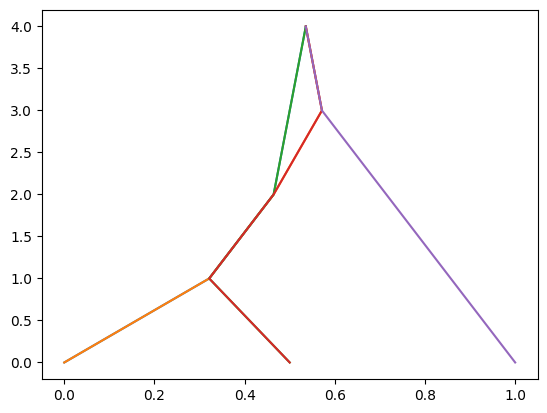

In [71]:
for p in paths:
    p_times = []
    p_locs = []
    for n in p:
        p_times.append(times[n])
        p_locs.append(locations[n])
    plt.plot(p_locs, p_times)
plt.show()

In [72]:
locations

array([0.        , 0.5       , 1.        , 0.32142857, 0.46428571,
       0.46428571, 0.57142857, 0.53571429])

In [73]:
paths = identify_unique_paths(ts=ts)
del paths[1]
del paths[1]

times, locations, dispersal_rate, cov_mat = reconstruct_node_locations(
    ts=ts,
    paths=paths,
    sample_locs=sample_locs
)

print("Estimated Dispersal Rate:", dispersal_rate)

[[3, 4, 7], [4, 7], [5, 6, 7], [6, 7], [0, 3, 4, 7], [1, 3, 5, 6, 7], [2, 6, 7]]
Estimated Dispersal Rate: [0.125]


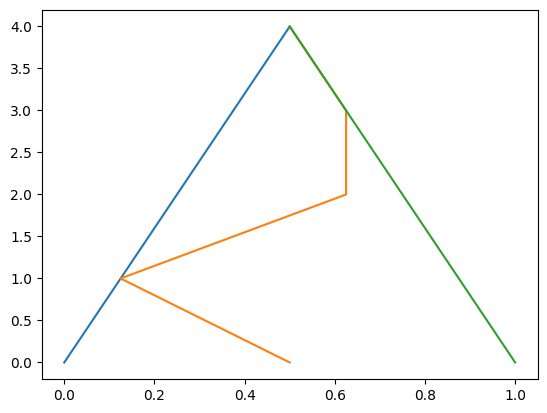

In [74]:
for p in paths:
    p_times = []
    p_locs = []
    for n in p:
        p_times.append(times[n])
        p_locs.append(locations[n])
    plt.plot(p_locs, p_times)
plt.show()

In [75]:
cov_mat

array([[4., 1., 0.],
       [1., 4., 1.],
       [0., 1., 4.]])

In [76]:
locations

array([0.   , 0.5  , 1.   , 0.125, 0.25 , 0.625, 0.625, 0.5  ])